# I- Corrélation entre attributs et suppression manuelle de quelques features


In [ ]:
%pip install pandas

In [ ]:
%pip install matplotlib

In [ ]:
%pip install jinja2

In [ ]:
%pip install scikit-learn

In [ ]:
%pip install seaborn

In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72872 entries, 0 to 72871
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Num_Acc                   72872 non-null  int64  
 1   num_veh                   72872 non-null  int32  
 2   id_usa                    72872 non-null  int64  
 3   date                      72872 non-null  int64  
 4   ville                     72872 non-null  int32  
 5   id_code_insee             72872 non-null  int32  
 6   latitude                  72872 non-null  float64
 7   longitude                 72872 non-null  float64
 8   descr_cat_veh             72872 non-null  int64  
 9   descr_agglo               72872 non-null  int32  
 10  descr_athmo               72872 non-null  int32  
 11  descr_lum                 72872 non-null  int32  
 12  descr_etat_surf           72872 non-null  int32  
 13  description_intersection  72872 non-null  int32  
 14  an_nai

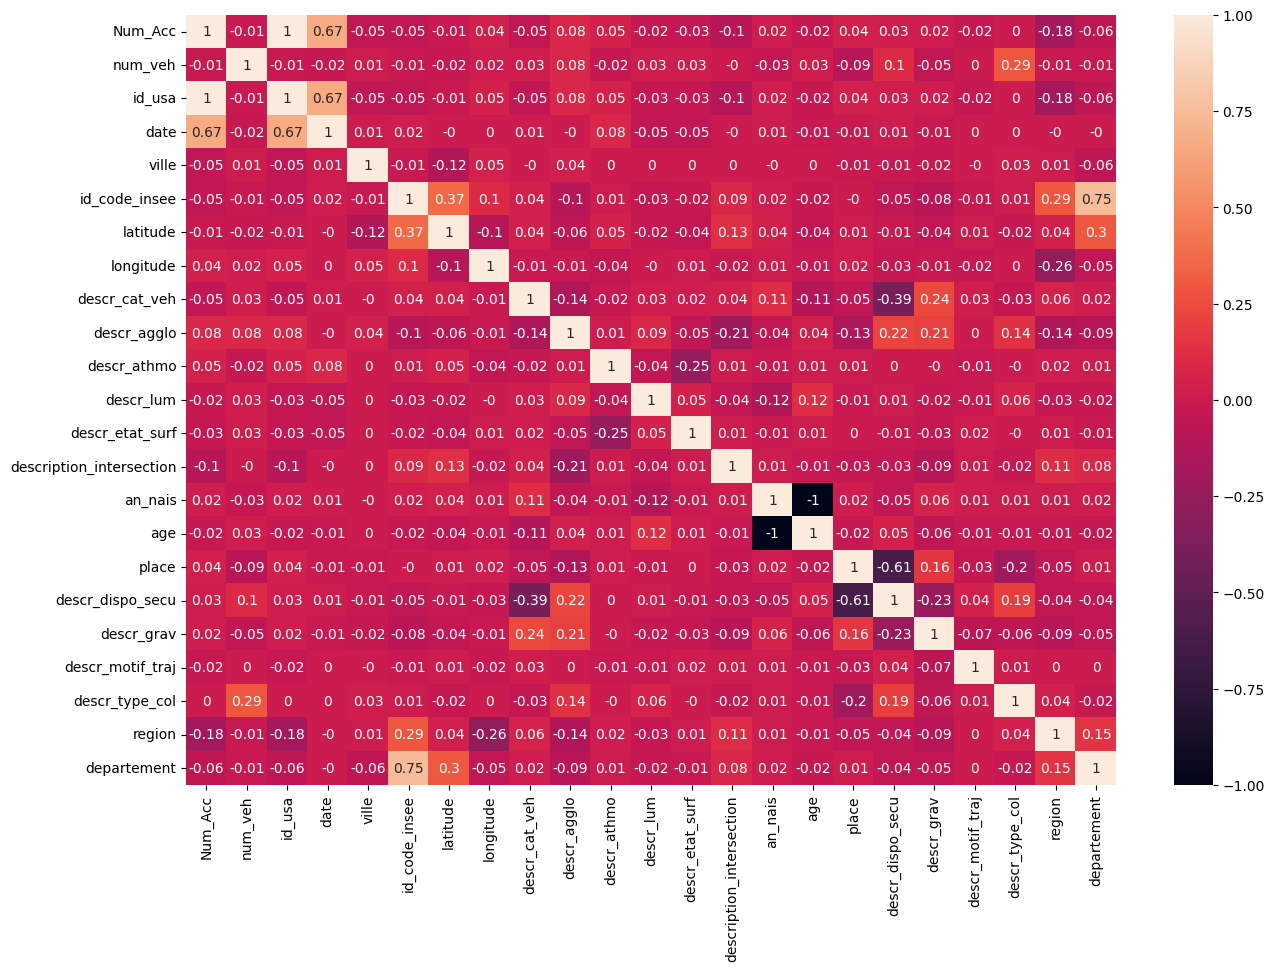

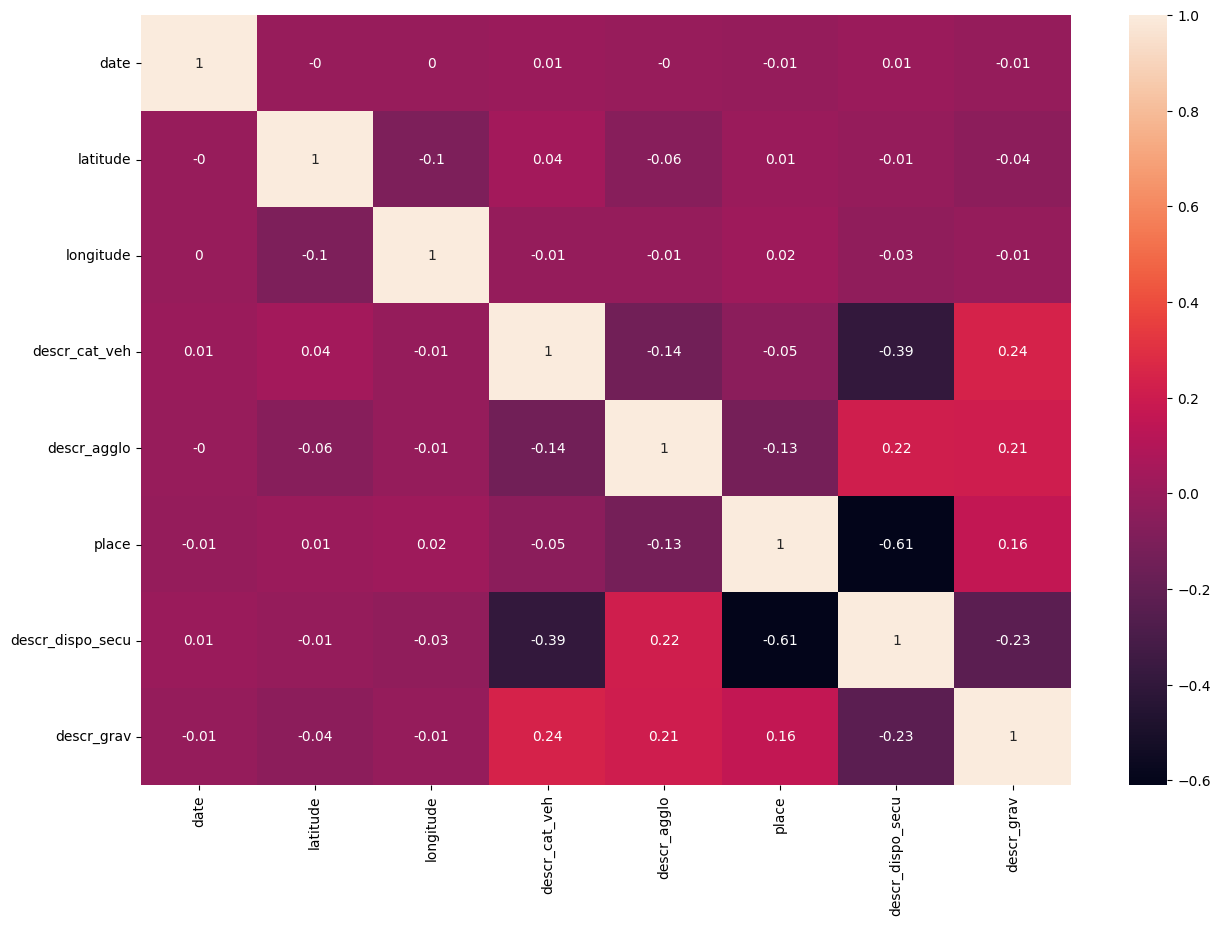

In [7]:
df = pd.read_csv('../df.csv')

enc = preprocessing.LabelEncoder()
#convertit en numérique les colonnes et évite de convertir les colonnes latitude et longitude pour garder les bonnes valeur pour les graphiques

for column_name in df:
    if column_name != 'longitude' and column_name != 'latitude':
        if not column_name.isnumeric()  :
            df[column_name] = enc.fit_transform(df[column_name])


df.info()
df
#matrice de correlation
corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()

#supprimer colonne
del df['Num_Acc']
del df['num_veh']
del df['id_usa']
del df['ville']
del df['id_code_insee']
del df['descr_athmo']
del df['descr_lum']
del df['descr_etat_surf']
del df['description_intersection']
del df['an_nais']
del df['age']
del df['descr_motif_traj']
del df['descr_type_col']
del df['region']
del df['departement']

corr_df = df.corr(method='pearson')

plt.figure(figsize=(15, 10))
sns.heatmap(round(corr_df,2), annot=True)
plt.xticks(rotation=90)
plt.show()
#del df['nom colonne']


# Partionnement ( Clustering )

## k-means from scikit-learn

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances

# Charger les données (latitude, longitude) dans un DataFrame
data = df[['latitude', 'longitude']]

# Liste des nombres de clusters à tester
n_clusters = [2, 3, 4, 5, 6]

# Effectuer le clustering pour chaque nombre de clusters
for n in n_clusters:
    # Instancier le modèle K-means
    kmeans = KMeans(n_clusters=n, random_state=42)
    print(kmeans)
    # Effectuer le clustering
    kmeans.fit(data)
    # Assigner les clusters aux points de données
    labels = kmeans.labels_
    #obtention coordonnées des centroïdes 
    centroids = kmeans.cluster_centers_
    #qualite_clustering = metrics.silhouette_score(data,labels, metric='euclidean')
    #print(qualite_clustering)
    
    # Afficher le résultat du clustering
    plt.scatter(data['longitude'], data['latitude'], c=labels)
    plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', color='red')
    plt.title(f"Clustering with {n} clusters")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\mathi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\m

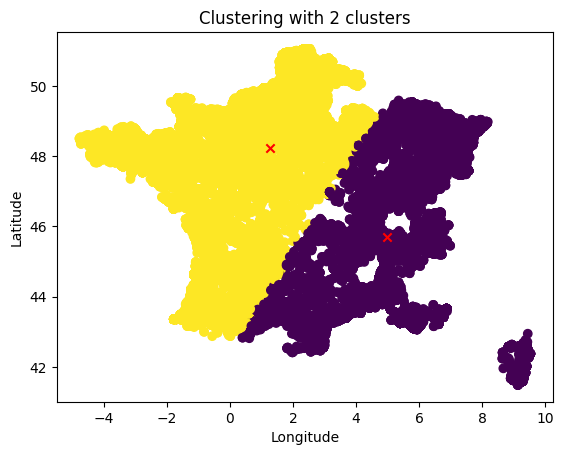

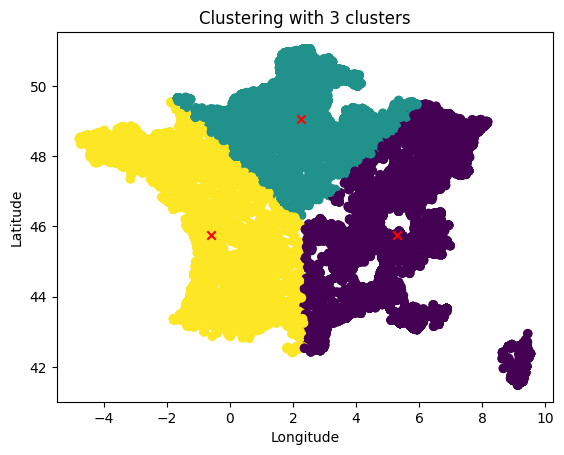

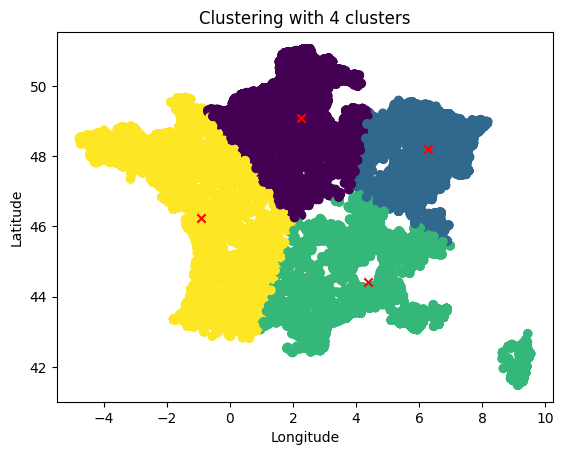

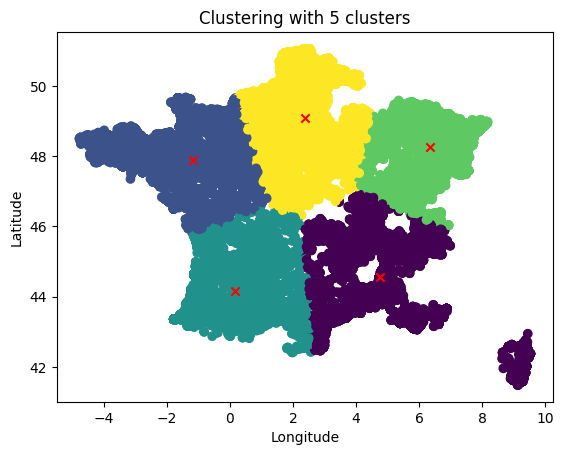

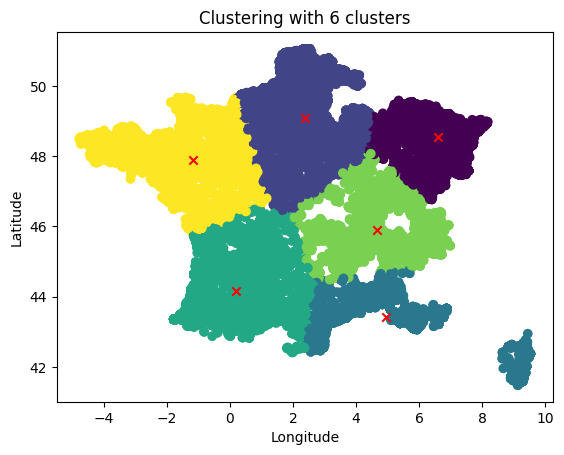

TypeError: 'numpy.float64' object does not support item assignment

In [40]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import pairwise_distances

def sklearn_clustering(data, n_clusters):
    # Dictionnaire pour stocker les résultats des clusters
    results = {}
    
    # Effectuer le clustering pour chaque nombre de clusters
    for n in n_clusters:
        # Instancier le modèle K-means
        kmeans = KMeans(n_clusters=n, random_state=42)
        # Effectuer le clustering
        kmeans.fit(data)
        # Assigner les clusters aux points de données
        labels = kmeans.labels_
        #obtention coordonnées des centroïdes 
        centroids = kmeans.cluster_centers_
        #qualite_clustering = metrics.silhouette_score(data, labels, metric='euclidean')
        #print(qualite_clustering)
        # Stocker les résultats des clusters
        results[n] = {'labels': labels, 'centroids': centroids}
    
    # Affichage des résultats des clusters pour chaque nombre de clusters
    for n, result in results.items():
        labels = result['labels']
        centroids = result['centroids']
        
        # Afficher le résultat du clustering
        plt.scatter(data['longitude'], data['latitude'], c=labels)
        plt.scatter(centroids[:, 1], centroids[:, 0], marker='x', color='red')
        plt.title(f"Clustering with {n} clusters")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

data = df[['latitude', 'longitude']]
n_clusters = [2, 3, 4, 5, 6]
sklearn_clustering(data, n_clusters)
for n in n_clusters:
    qualite_clustering[n] = metrics.silhouette_score(data, labels, metric='euclidean')
#affiche juste le dernier silhouette score du dernier nombre de cluster (ici 6)
    print(qualite_clustering[n])


## k-means from scratch

In [9]:
import matplotlib.pyplot as plt

In [10]:
from math import floor
import numpy as np


def naiveShard(df, k):
    
    n = df.shape[1]
    m = df.shape[0]
    centroidf = np.mat(np.zeros((k, n)))

    # Sum all elements of each row, add as col to original dataset, sort
    composite = np.mat(df.sum(axis=1))
    df = np.append(composite.T, df, axis=1)
    df.sort(axis=0)

    # Step value for dataset sharding
    step = floor(m / k)

    # Vectorize mean ufunc for numpy array
    vfunc = np.vectorize(_get_mean)

    # Divide matrix rows equally by k-1 (so that there are k matrix shardf)
    # Sum columns of shardf, get means; these columnar means are centroidf
    for j in range(k):
        if j == k - 1:
            centroidf[j:] = vfunc(np.sum(df[j * step:, 1:], axis=0), step)
        else:
            centroidf[j:] = vfunc(np.sum(df[j * step:(j + 1) * step, 1:], axis=0), step)

    return centroidf

def _get_mean(sums, step):
    return sums / step


In [11]:
import sklearn.preprocessing


def Kmeans(NbCentroids,daf):
    clusterList = [[] for _ in range(NbCentroids)]
    daf = daf[['latitude','longitude']]
  
    #on va utiliser la méthode par naive sharding
    minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
    X_scaled = minmax_scaler.fit_transform(daf)
    centroids = naiveShard(X_scaled, k=NbCentroids)
    centroids = minmax_scaler.inverse_transform(np.array(centroids))

    #pour chaque accident on regarde quel est le centroide le plus proche

    for index, row in daf.iterrows():
        pt = [row['latitude'],row['longitude']]
        distlist = [[] for _ in range(NbCentroids)]
        for i in range(len(centroids)):
            distlist[i] = np.linalg.norm(np.array(pt) - centroids[i]) #dist eucl*
        min_index = distlist.index(min(distlist))
        clusterList[min_index].append(pt)

    return clusterList,centroids
    


In [12]:
a = Kmeans(3,data)

In [13]:
print(a)

([[[47.4833, -1.23333], [42.7667, 2.98333], [45.9667, 0.066667], [48.2833, -4.05], [48.1667, -3.78333], [43.75, -0.35], [43.6167, -0.633333], [43.6167, -0.633333], [44.4833, 2.4], [44.1167, 3.83333], [47.9333, -1.6], [47.8167, -1.95], [47.8167, -1.95], [47.7, -2.0], [47.7, -2.0], [47.35, -0.85], [47.1333, -0.15], [43.9353, 4.32167], [43.8, 4.25], [45.6333, -0.65], [44.2, 3.18333], [46.5833, 0.266667], [46.1833, -1.06667], [46.6167, 0.433333], [45.1333, 0.85], [45.25, 1.15], [43.9, 2.0], [43.6167, 3.73333], [43.8333, 3.91667], [43.4167, 3.3], [43.65, 3.55], [43.3, 3.41667], [43.6667, 1.48333], [47.7833, -3.41667], [47.6833, -2.55], [47.5333, -2.76667], [47.5333, -2.76667], [47.5333, -1.88333], [47.1667, -1.26667], [47.6333, -2.13333], [45.3833, 1.36667], [45.3167, 1.76667], [44.2, 4.15], [46.9, -0.333333], [42.6333, 2.75], [42.4667, 1.93333], [42.5833, 2.11667], [43.6833, 1.4], [42.55, 1.83333], [46.8667, -1.1], [46.5833, -1.51667], [46.6667, -1.43333], [46.6667, -1.43333], [46.6167, -1

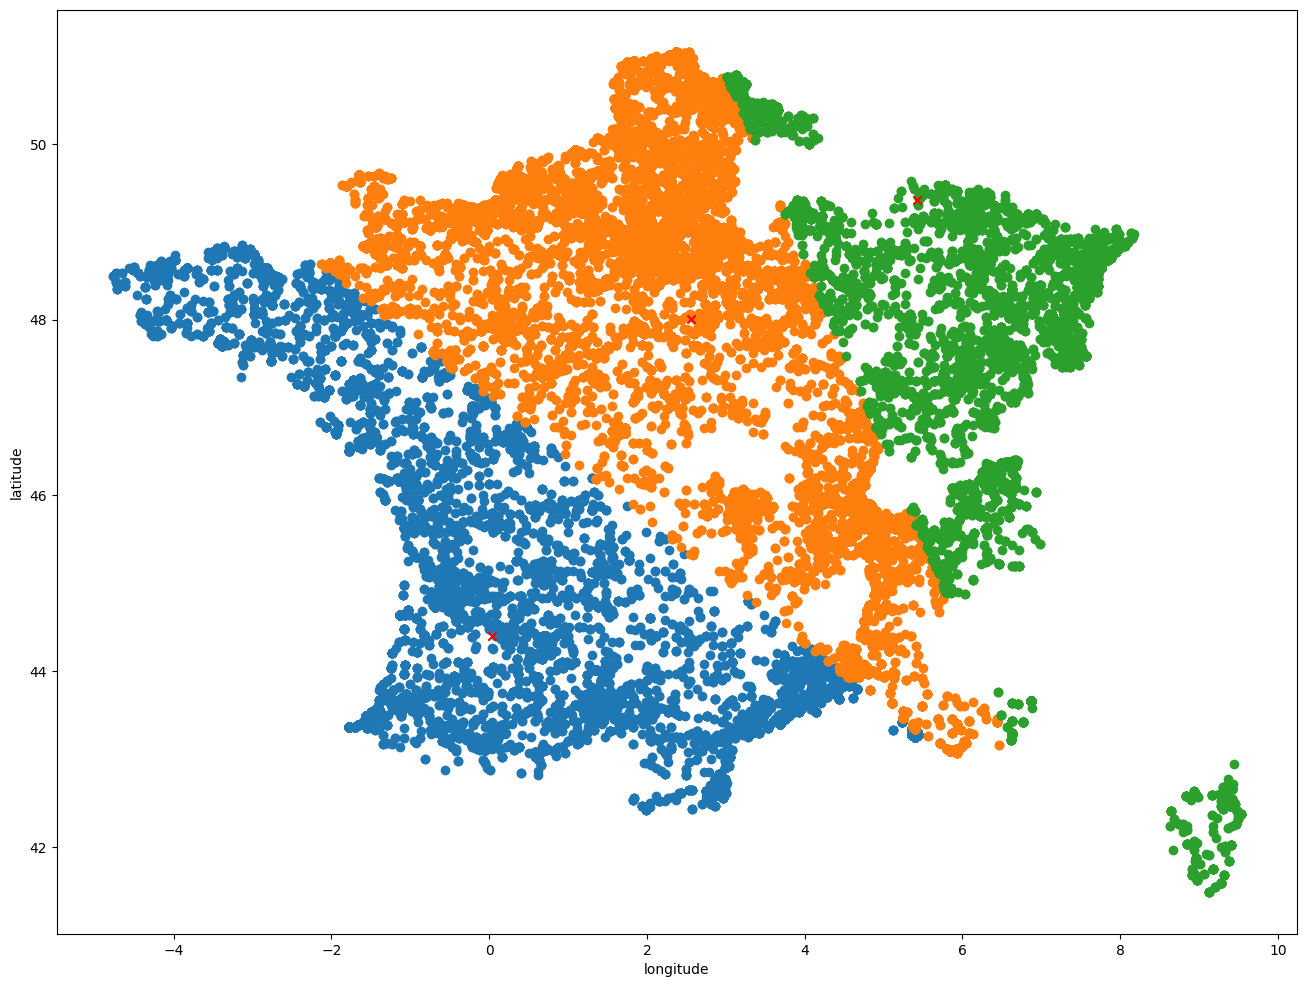

In [14]:
colors = ['red', 'green', 'blue', 'orange', 'purple']  # Add more colors if needed

fig = plt.figure(figsize=(16,12))  # Width: 8 inches, Height: 6 inches
plt.xlabel("longitude")
plt.ylabel("latitude")


# Iterate over each cluster
for cluster in a[0]:
    # Extract x and y coordinates for the current cluster
    y_coords = [coord[0] for coord in cluster]
    x_coords = [coord[1] for coord in cluster]


    # Plot scatter for the current cluster
    
    plt.scatter(x_coords, y_coords)
    
centroids = a[1]
plt.scatter(centroids[:, 1], centroids[:, 0], c='red', marker='x')


(apparté pour tester la méthode Naive SHarding)

le test avec nos données en pandas df

In [15]:
import sklearn.preprocessing

# Scale dataset
minmax_scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(0, 1))
X_scaled = minmax_scaler.fit_transform(data)
centroids = naiveShard(X_scaled, 3)
print(centroids)


[[0.30480851 0.33569176]
 [0.68225776 0.5124189 ]
 [0.82374934 0.71279196]]
